<a href="https://colab.research.google.com/github/dprice80/colab/blob/master/Deep_Multitask_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 3.6MB 5.9MB/s 


In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteQODZHJ/movielens-train.tfrecord


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [ ]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [ ]:
import pdb

# Create function to extract numpy arrays into memory
# This only works on datasets of Dicts
def extract_numpy_arrays(x, cols):

  extracted = dict()

  # Create a single batch
  xb = x.batch(len(x))

  # Get the first item from the iterable returned above
  first_element = next(iter(xb))

  # Index the required fields, convert to numpy and add to dict
  for c in cols:
    extracted[c] = first_element[c].numpy().flatten()

  return extracted

In [ ]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
    "user_rating": x["user_rating"]
})

# The following operations are now much faster than converting to pandas dataframe

ratings_np = extract_numpy_arrays(ratings, ['movie_title', 'user_id', 'timestamp', 'user_rating'])
ratings = tf.data.Dataset.from_tensor_slices(ratings_np)

# Get unique movies and create new dataset
movies = tf.data.Dataset.from_tensor_slices(
    np.unique(ratings_np['movie_title'])
)

In [ ]:
unique_user_ids = np.unique(ratings_np['user_id'])
unique_movie_titles = np.unique(ratings_np['movie_title'])

In [ ]:
timestamps = ratings_np["timestamp"]

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [ ]:
num_epochs = 20

## Define some models to create deep embeddings

In [ ]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        self.normalized_timestamp(inputs["timestamp"]),
    ], axis=1)

In [ ]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [ ]:
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [ ]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

## Deep retrieval model

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(
        query_embeddings, movie_embeddings)

In [ ]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0)


train_accuracy = two_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
val_accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy train: {train_accuracy:.2f}.")
print(f"Top-100 accuracy val: {val_accuracy:.2f}.")

Top-100 accuracy train: 0.36.
Top-100 accuracy val: 0.26.


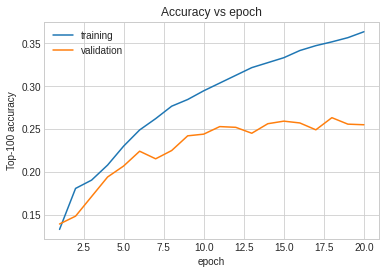

In [ ]:
num_validation_runs = len(two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, two_layer_history.history["factorized_top_k/top_100_categorical_accuracy"], label="training")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="validation")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [ ]:
train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

5/5 [==============================] - 4s 741ms/step - factorized_top_k/top_1_categorical_accuracy: 8.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0066 - factorized_top_k/top_10_categorical_accuracy: 0.0166 - factorized_top_k/top_50_categorical_accuracy: 0.1247 - factorized_top_k/top_100_categorical_accuracy: 0.2551 - loss: 30788.7061 - regularization_loss: 0.0000e+00 - total_loss: 30788.7061
Top-100 accuracy (train): 0.37.
Top-100 accuracy (test): 0.26.


## Multitask Model

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0)


train_accuracy = history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
val_accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy train: {train_accuracy:.2f}.")
print(f"Top-100 accuracy val: {val_accuracy:.2f}.")

Top-100 accuracy train: 0.42.
Top-100 accuracy val: 0.17.


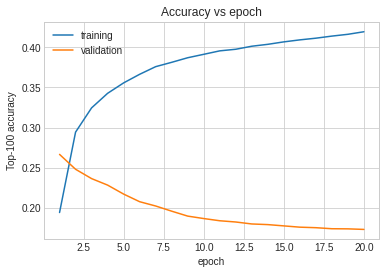

In [ ]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, history.history["factorized_top_k/top_100_categorical_accuracy"], label="training")
plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="validation")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [ ]:
train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

5/5 [==============================] - 4s 706ms/step - root_mean_squared_error: 0.9597 - factorized_top_k/top_1_categorical_accuracy: 2.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0027 - factorized_top_k/top_10_categorical_accuracy: 0.0067 - factorized_top_k/top_50_categorical_accuracy: 0.0740 - factorized_top_k/top_100_categorical_accuracy: 0.1730 - loss: 32220.6419 - regularization_loss: 0.0000e+00 - total_loss: 32220.6419
Top-100 accuracy (train): 0.43.
Top-100 accuracy (test): 0.17.


## Deep multitask model

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self,
               rating_weight: float,
               retrieval_weight: float,
               layer_sizes: list) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    # User and movie models.
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return (
        query_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([query_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    query_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(query_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0, layer_sizes=[64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=0)


train_accuracy = history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
val_accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy train: {train_accuracy:.2f}.")
print(f"Top-100 accuracy val: {val_accuracy:.2f}.")

Top-100 accuracy train: 0.36.
Top-100 accuracy val: 0.26.


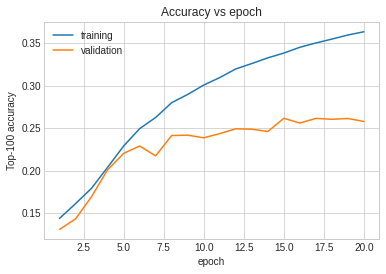

In [ ]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, history.history["factorized_top_k/top_100_categorical_accuracy"], label="training")
plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="validation")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [ ]:
train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

5/5 [==============================] - 4s 726ms/step - root_mean_squared_error: 1.0371 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0072 - factorized_top_k/top_10_categorical_accuracy: 0.0171 - factorized_top_k/top_50_categorical_accuracy: 0.1267 - factorized_top_k/top_100_categorical_accuracy: 0.2578 - loss: 30832.1963 - regularization_loss: 0.0000e+00 - total_loss: 30832.1963
Top-100 accuracy (train): 0.38.
Top-100 accuracy (test): 0.26.


In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model.candidate_model), movies)

# Get recommendations.
_, titles = index({
        "user_id": tf.constant(["42"]),
        "timestamp": tf.constant([879024327]),
    })
print(f"Recommendations for user 42 at timestamp 879024327: {titles[0, :3]}")

Recommendations for user 42 at timestamp 879024327: [b'Kazaam (1996)' b'Black Sheep (1996)' b'Last Dance (1996)']


In [ ]:
rating_prediction = model.rating_model.predict(tf.concat([
                        model.query_model({
                            "user_id": tf.constant(["42"]),
                            "timestamp": tf.constant([879024327]),
                        }),
                        model.candidate_model(tf.constant(["One Flew Over the Cuckoo's Nest (1975)"]))], axis=1))
print(f"Rating prediction for user 42 at timestamp 879024327 on movie One Flew Over the Cuckoo's Nest (1975): {rating_prediction[0][0]}")

Rating prediction for user 42 at timestamp 879024327 on movie One Flew Over the Cuckoo's Nest (1975): 4.116105556488037


## Model Summaries for deep multitask model

In [ ]:
unique_user_ids.shape

(943,)

In [ ]:
unique_movie_titles.shape

(1664,)

In [ ]:
timestamp_buckets.shape

(1000,)

In [ ]:
model.query_model.embedding_model.summary()

Model: "user_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                30208     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                32032     
_________________________________________________________________
normalization (Normalization multiple                  3         
Total params: 62,243
Trainable params: 62,240
Non-trainable params: 3
_________________________________________________________________


In [ ]:
model.query_model.dense_layers.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
Total params: 6,304
Trainable params: 6,304
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.query_model.summary()

Model: "query_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_model (UserModel)       multiple                  62243     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32)                6304      
Total params: 68,547
Trainable params: 68,544
Non-trainable params: 3
_________________________________________________________________


In [ ]:
model.candidate_model.embedding_model.summary()

Model: "movie_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32)                53280     
_________________________________________________________________
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                320000    
Total params: 373,280
Trainable params: 373,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.candidate_model.dense_layers.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 6,240
Trainable params: 6,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.candidate_model.summary()

Model: "candidate_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
movie_model (MovieModel)     multiple                  373280    
_________________________________________________________________
sequential_5 (Sequential)    (None, 32)                6240      
Total params: 379,520
Trainable params: 379,520
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.rating_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
